In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 



def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

train = pd.read_csv('../raw_data/train.csv', index_col = 0)
test = pd.read_csv('../raw_data/test.csv', index_col = 0)
it_imputer = IterativeImputer(max_iter=10)
train_pop = train['song_popularity']
useful_cols = [col for col in train.columns if col not in ['id','song_popularity']]
train_iterimp = it_imputer.fit_transform(train[useful_cols])
train = pd.DataFrame(train_iterimp, columns=useful_cols)

In [213]:
train['instrumentalness_gaussian'] = train['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
train['instrumentalness_skewed'] = train['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)
train['log_instrumentalness'] = train['instrumentalness'].apply(lambda x: np.log(x+1) )
train['log_instrumentalness_skewed'] = train['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.11 else 0)
train['log_instrumentalness_gaussian'] = train['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.01 else -1)

train['log_acousticness'] = train['acousticness'].apply(lambda x: np.log(x+1) )
train['log_liveness'] = train['liveness'].apply(lambda x: np.log(x+1) )
train['log_audio_valence'] = train['audio_valence'].apply(lambda x: np.log(x+1) )

# train['new_feat1'] = train['key']**(train['time_signature']+1)/(train['audio_mode']+1)
train['new_feat2'] = np.log(train['energy']+1)*train['log_liveness']*train['tempo']
train['new_feat3'] = np.log(train['speechiness'])*train['log_acousticness']
train['new_feat4'] = train['energy']*(train['audio_mode']+1)

<AxesSubplot:ylabel='Density'>

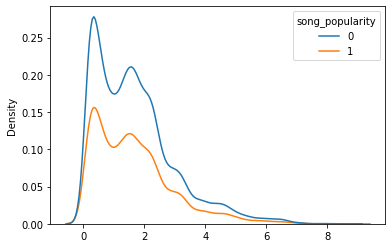

In [146]:
sns.kdeplot(data = train, x = train['energy']*(train['time_signature'])*(train['audio_mode']+1)*(train['key']+1), hue=train['song_popularity'])

<AxesSubplot:ylabel='count'>

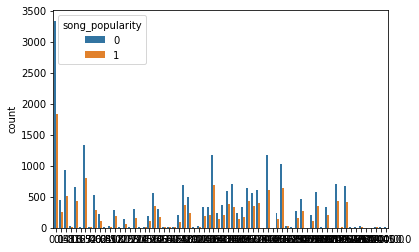

In [151]:
sns.countplot(data = train, x = train['key']**(train['time_signature']+1)/(train['audio_mode']+1), hue=train['song_popularity'])

<AxesSubplot:ylabel='Density'>

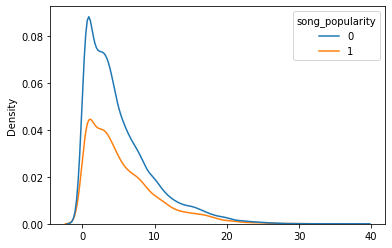

In [40]:
sns.kdeplot(data = train, x = np.log(train['audio_valence'])*train['log_liveness'], hue=train['song_popularity'])

<AxesSubplot:ylabel='Density'>

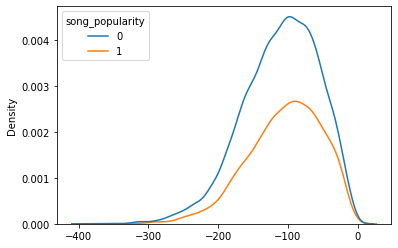

In [46]:
sns.kdeplot(data = train, x = np.log(train['energy']+1)*train['log_liveness']*train['tempo'], hue=train['song_popularity'])

In [214]:

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# it_imputer = IterativeImputer(max_iter=10)
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity', 'instrumentalness', 'acousticness', 'liveness', 'audio_valence', 'instrumentalness_gaussian', 'instrumentalness_skewed','log_instrumentalness','audio_mode']]
# train_iterimp = it_imputer.fit_transform(train[useful_cols])
# test_iterimp = it_imputer.transform(test[useful_cols])

# df_train_iterimp = pd.DataFrame(train_iterimp, columns=useful_cols)

X_train, X_valid, y_train, y_valid = train_test_split(train[useful_cols], train_pop, test_size=0.2, random_state=42)

In [169]:
X_train.head()

,song_duration_ms,danceability,energy,key,loudness,audio_mode,speechiness,tempo,time_signature,instrumentalness_gaussian,log_instrumentalness,log_instrumentalness_skewed,log_instrumentalness_gaussian,log_acousticness,log_liveness,log_audio_valence,new_feat2,new_feat3,new_feat4
14307,209771.0,0.396354,0.557945,9.000000,-13.563839,0.0,0.034208,130.463575,3.0,-1.0,-6.239626,0.0,-1.0,0.146178,-1.038629,-0.768399,-60.077774,-0.493392,0.557945
17812,48557.0,0.170351,0.214716,0.000000,-17.235919,0.0,0.046381,79.602008,3.0,-1.0,-4.643844,0.0,-1.0,0.675743,-1.933844,-2.104835,-29.942561,-2.075120,0.214716
11020,159853.0,0.888235,0.704658,4.857177,-5.662873,1.0,0.044131,102.276776,3.0,-1.0,-6.407983,0.0,-1.0,0.563415,-2.363270,-0.282142,-128.918326,-1.758185,1.409317
15158,236432.0,0.406576,0.657219,4.000000,-8.471483,0.0,0.101626,109.153270,3.0,-1.0,-6.838113,0.0,-1.0,0.213486,-2.002229,-1.138270,-110.398419,-0.488128,0.657219
24990,212338.0,0.680878,0.884256,6.000000,-4.810555,0.0,0.185004,120.147118,4.0,-1.0,-5.976831,0.0,-1.0,0.186877,-2.218518,-0.428690,-168.867297,-0.351451,0.884256


In [215]:
from skopt import BayesSearchCV

param = {'n_estimators': (100, 500),
         'max_features': ['auto', 'sqrt', 'log2'],
         'max_depth': (1, 50),
         'min_samples_split': (2, 100),
         'min_samples_leaf': (1, 50),
         'class_weight': ['balanced', None, 'balanced_subsample'],
}


opt = BayesSearchCV(RandomForestClassifier(), param, n_iter=50, cv=5, scoring='roc_auc', random_state=42, n_jobs = 5)

opt.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=5,
              random_state=42, scoring='roc_auc',
              search_spaces={'class_weight': ['balanced', None,
                                              'balanced_subsample'],
                             'max_depth': (1, 50),
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': (1, 50),
                             'min_samples_split': (2, 100),
                             'n_estimators': (100, 500)})

In [216]:
opt_best = opt.best_estimator_
opt.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=50,
                       n_estimators=500)

In [217]:
# opt_best = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=11, min_samples_split=19, min_samples_leaf=29, class_weight='balanced_subsample', random_state = 42)


opt_best.fit(X_train, y_train)
print(opt_best.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, opt_best.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.553125
AUC: 0.5680194496060134


<AxesSubplot:ylabel='cols'>

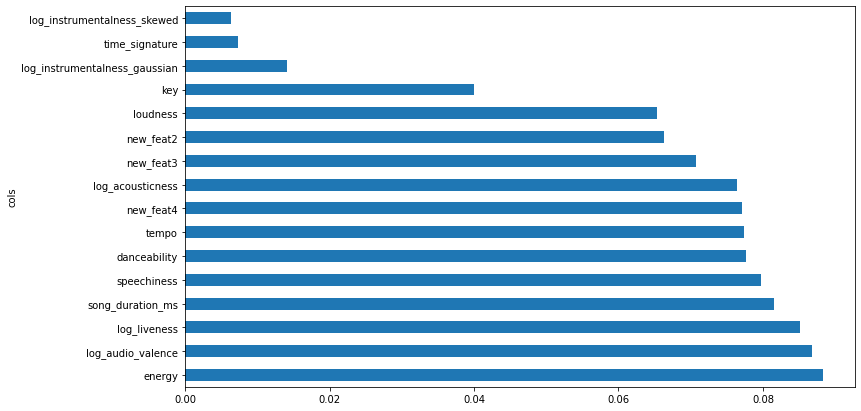

In [208]:
fi = rf_feat_importance(opt_best, X_train)
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi)

In [218]:
useful_cols = [col for col in test.columns if col not in ['id']]

test_iterimp = it_imputer.transform(test[useful_cols])

test = pd.DataFrame(test_iterimp, columns=useful_cols)

test['instrumentalness_gaussian'] = test['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
test['instrumentalness_skewed'] = test['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)
test['log_instrumentalness'] = test['instrumentalness'].apply(lambda x: np.log(x+1) )
test['log_instrumentalness_skewed'] = test['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.11 else 0)
test['log_instrumentalness_gaussian'] = test['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.01 else -1)

test['log_acousticness'] = test['acousticness'].apply(lambda x: np.log(x+1) )
test['log_liveness'] = test['liveness'].apply(lambda x: np.log(x+1) )
test['log_audio_valence'] = test['audio_valence'].apply(lambda x: np.log(x+1) )

# test['new_feat1'] = test['key']**(test['time_signature']+1)/(test['audio_mode']+1)
test['new_feat2'] = np.log(test['energy']+1)*test['log_liveness']*test['tempo']
test['new_feat3'] = np.log(test['speechiness'])*test['log_acousticness']
test['new_feat4'] = test['energy']*(test['audio_mode']+1)

useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity', 'instrumentalness', 'acousticness', 'liveness', 'audio_valence', 'instrumentalness_gaussian', 'instrumentalness_skewed','log_instrumentalness','audio_mode']]


submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)
submission['song_popularity'] = opt_best.predict_proba(test[useful_cols])[:,1]
submission.head()
submission.to_csv('../submissions/submission_rf_balanced_subsample_bayes_opti.csv')

In [219]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train, y_train)
selected_features = X_train.columns[(sel_.get_support())]
print(selected_features)

Index(['danceability', 'energy', 'key', 'loudness', 'speechiness', 'tempo',
       'time_signature', 'log_instrumentalness_skewed',
       'log_instrumentalness_gaussian', 'log_liveness', 'log_audio_valence',
       'new_feat2', 'new_feat3', 'new_feat4'],
      dtype='object')


In [226]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

from skopt import BayesSearchCV

n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)



opt_gb = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = grid, n_iter=20, cv=5, scoring='roc_auc', random_state=42, n_jobs = 5)

opt_gb.fit(X_train, y_train)



RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=5,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 7, 9],
                                        'n_estimators': [10, 100, 1000],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='roc_auc')

In [228]:
opt_gb_best = opt_gb.best_params_
opt_gb_best

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}

In [229]:
opt_gb_top = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, subsample=0.5, max_depth=3, random_state=42)
opt_gb_top = opt_gb_top.fit(X_train, y_train)

In [230]:
print(opt_gb_top.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, opt_gb_top.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.63475
AUC: 0.5717563002060405


In [232]:
train['GBC'] = opt_gb_top.predict_proba(train[useful_cols])[:,1]

useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity', 'instrumentalness', 'acousticness', 'liveness', 'audio_valence', 'instrumentalness_gaussian', 'instrumentalness_skewed','log_instrumentalness','audio_mode']]


X_train, X_valid, y_train, y_valid = train_test_split(train[useful_cols], train_pop, test_size=0.2, random_state=42)
opt_best.fit(X_train, y_train)
print(opt_best.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, opt_best.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.5505
AUC: 0.5712460423628091


<AxesSubplot:ylabel='cols'>

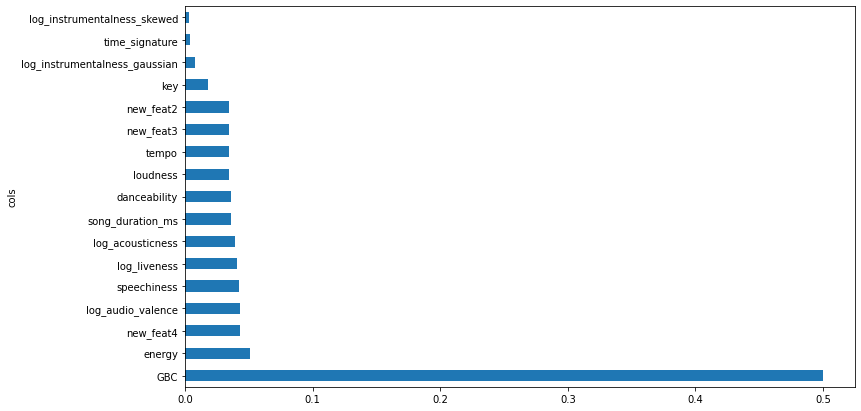

In [236]:
fi = rf_feat_importance(opt_best, X_train)
plot_fi(fi)

In [235]:
test = pd.read_csv('../raw_data/test.csv', index_col = 0)
useful_cols = [col for col in test.columns if col not in ['id']]

test_iterimp = it_imputer.transform(test[useful_cols])

test = pd.DataFrame(test_iterimp, columns=useful_cols)

test['instrumentalness_gaussian'] = test['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
test['instrumentalness_skewed'] = test['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)
test['log_instrumentalness'] = test['instrumentalness'].apply(lambda x: np.log(x+1) )
test['log_instrumentalness_skewed'] = test['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.11 else 0)
test['log_instrumentalness_gaussian'] = test['instrumentalness'].apply(lambda x: np.log(x+1) if x > 0.01 else -1)

test['log_acousticness'] = test['acousticness'].apply(lambda x: np.log(x+1) )
test['log_liveness'] = test['liveness'].apply(lambda x: np.log(x+1) )
test['log_audio_valence'] = test['audio_valence'].apply(lambda x: np.log(x+1) )

# test['new_feat1'] = test['key']**(test['time_signature']+1)/(test['audio_mode']+1)
test['new_feat2'] = np.log(test['energy']+1)*test['log_liveness']*test['tempo']
test['new_feat3'] = np.log(test['speechiness'])*test['log_acousticness']
test['new_feat4'] = test['energy']*(test['audio_mode']+1)
useful_cols = [col for col in test.columns if col not in ['id', 'song_popularity', 'instrumentalness', 'acousticness', 'liveness', 'audio_valence', 'instrumentalness_gaussian', 'instrumentalness_skewed','log_instrumentalness','audio_mode']]

test['GBC'] = opt_gb_top.predict_proba(test[useful_cols])[:,1]
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity', 'instrumentalness', 'acousticness', 'liveness', 'audio_valence', 'instrumentalness_gaussian', 'instrumentalness_skewed','log_instrumentalness','audio_mode']]


submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)
submission['song_popularity'] = opt_best.predict_proba(test[useful_cols])[:,1]
submission.head()
submission.to_csv('../submissions/submission_rf_balanced_subsample_bayes_opti_bdc.csv')